In [76]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, auc, log_loss
import optuna
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.base import BaseEstimator, ClassifierMixin
from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer
from torch.utils.data import DataLoader, TensorDataset
from sklearn.calibration import calibration_curve, CalibratedClassifierCV
import torch.nn.functional as F

import warnings
warnings.filterwarnings('ignore')

In [111]:
data = pd.read_csv('data_featured_4235_except_zeros.csv', index_col='Unnamed: 0')
data = data.loc[:2200, :]

In [112]:
X = data.drop(['Result'], axis=1)
y = data['Result']

In [113]:
test_size = int(len(X)*0.1)

X_train = X.iloc[test_size:, :]
y_train = y.iloc[test_size:]
X_test = X.iloc[:test_size, :]
y_test = y.iloc[:test_size]

In [114]:
X_train

,WeightClass,RedStance,BlueStance,Age_diff,Height_diff,Reach_diff,Weight_diff,Red_wins_loss_diff,Blue_wins_loss_diff,Red_Blue_Wins_diff,Red_Blue_Loss_diff,Red_Blue_wins_loss_diff,AvgSigStrLanded_diff,AvgSigStrPct_diff,TDAvgLanded_diff,AvgTDPct_diff,AvgSubAtt_diff,Red_Blue_curr_streak_diff
213,1,1.0,1.0,1,-10.16,-12.70,0,0,-4,7,3,4,-0.65,-0.03,0.07,0.11,0.3,1
214,0,0.0,1.0,-5,-7.62,-2.54,0,3,2,4,3,1,1.74,-0.03,0.70,0.17,-1.9,0
215,3,1.0,1.0,-1,0.00,-7.62,0,1,0,0,-1,1,-0.18,-0.04,2.61,0.27,-0.8,0
216,0,1.0,1.0,1,-5.08,5.08,0,3,-4,3,-4,7,1.21,0.13,-0.36,0.06,0.0,4
217,7,1.0,0.0,6,2.54,12.70,-25,2,0,2,0,2,-0.91,-0.25,-1.80,-0.25,-0.4,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2195,1,1.0,1.0,6,-7.62,-5.08,0,4,2,6,4,2,-0.71,0.02,-7.91,-0.22,-0.3,-3
2196,3,0.0,1.0,-1,-5.08,-2.54,0,8,3,16,11,5,-0.48,-0.05,-2.32,-0.19,1.5,0
2197,0,0.0,1.0,3,10.16,15.24,0,-2,1,0,3,-3,1.31,0.05,-2.02,-0.12,-1.4,0
2198,0,1.0,1.0,3,2.54,2.54,0,2,0,4,2,2,2.56,-0.06,-3.03,-0.16,-1.2,-3


In [115]:
scaler = StandardScaler().set_output(transform='pandas')
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [534]:
stats_columns_featured = X_train.columns[3:]

In [ ]:
stats_columns = [#'RedAvgSigStrLanded',
                #'BlueAvgSigStrLanded',
                'RedAvgSigStrPct',
                'BlueAvgSigStrPct',
                'RedAvgSubAtt',
                'BlueAvgSubAtt',
                'RedAvgTDLanded',
                'BlueAvgTDLanded',
                'RedAvgTDPct',
                'BlueAvgTDPct'
                ]   

def stats_columns_hist(df, columns):
    fig, axs = plt.subplots(nrows=7, ncols=2, figsize=(12, 19), gridspec_kw={'hspace': 0.4, 'wspace': 0.4})
    for i in range(len(columns)):
        axs[int(i // 2), i % 2].hist(df[columns[i]], bins=30)
        axs[int(i // 2), i % 2].set_title(columns[i])
        axs[int(i // 2), i % 2].grid()

# stats_columns_hist(X_train, X_train.columns[3:])

### Базовая модель. 3 слоя

In [116]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np

# Определение датасета
class FighterDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        x = self.X.iloc[idx]
        y = self.y.iloc[idx]  # берем только первый столбец (класс)
        return {
            'x': torch.tensor(x, dtype=torch.float32),
            'y': torch.tensor(y, dtype=torch.long)
        }  

In [117]:
# Определение нейронной сети
class FighterNet(nn.Module):
    def __init__(self):
        super(FighterNet, self).__init__()
        self.fc1 = nn.Linear(18, 128)  # входной слой
        self.fc2 = nn.Linear(128, 64)  # скрытый слой
        self.fc3 = nn.Linear(64, 2)  # выходной слой 

        nn.init.kaiming_normal_(self.fc1.weight)
        nn.init.kaiming_normal_(self.fc2.weight)              

    def forward(self, x):
        x = torch.relu(self.fc1(x))  # активация ReLU
        x = torch.relu(self.fc2(x))  # активация ReLU
        x = self.fc3(x)
        return x      

### Больше слоев

In [86]:
class FighterNet(nn.Module):
    def __init__(self):
        super(FighterNet, self).__init__()
        self.fc1 = nn.Linear(18, 128)  # входной слой
        self.fc2 = nn.Linear(128, 64)  # скрытый слой
        self.fc3 = nn.Linear(64, 32)  # скрытый слой
        self.fc4 = nn.Linear(32, 2)  # выходной слой

        nn.init.kaiming_normal_(self.fc1.weight)
        nn.init.kaiming_normal_(self.fc2.weight) 
        nn.init.kaiming_normal_(self.fc3.weight) 

    def forward(self, x):
        x = torch.relu(self.fc1(x))  # активация ReLU
        x = torch.relu(self.fc2(x))  # активация ReLU
        x = torch.relu(self.fc3(x))  # активация ReLU
        x = self.fc4(x)
        return x

### Добавляем дропаут

In [90]:
class FighterNet(nn.Module):
    def __init__(self):
        super(FighterNet, self).__init__()
        self.fc1 = nn.Linear(18, 128)  # входной слой
        self.dropout1 = nn.Dropout(p=0.2)
        self.fc2 = nn.Linear(128, 128)  # скрытый слой
        self.dropout2 = nn.Dropout(p=0.2)
        self.fc3 = nn.Linear(128, 64)  # скрытый слой
        self.dropout3 = nn.Dropout(p=0.2)
        self.fc4 = nn.Linear(64, 64)  # скрытый слой
        self.dropout4 = nn.Dropout(p=0.2)
        self.fc5 = nn.Linear(64, 32)  # скрытый слой
        self.dropout5 = nn.Dropout(p=0.2)
        self.fc6 = nn.Linear(32, 2)  # выходной слой   

    def forward(self, x):        
        x = torch.relu(self.fc1(x))  # активация ReLU
        x = self.dropout1(x)
        x = torch.relu(self.fc2(x))  # активация ReLU
        x = self.dropout2(x)
        x = torch.relu(self.fc3(x))  # активация ReLU
        x = self.dropout3(x)
        x = torch.relu(self.fc4(x))  # активация ReLU
        x = self.dropout4(x)
        x = torch.relu(self.fc5(x))  # активация ReLU
        x = self.dropout5(x)
        x = self.fc6(x)
        return x

### Разные функции активации

In [63]:
class FighterNet(nn.Module):
    def __init__(self):
        super(FighterNet, self).__init__()
        self.fc1 = nn.Linear(18, 128)  # входной слой
        self.fc2 = nn.Linear(128, 64)  # скрытый слой
        self.fc3 = nn.Linear(64, 2)  # выходной слой

    def forward(self, x):
        x = torch.relu(self.fc1(x))  # функция активации sigmoid
        x = torch.sigmoid(self.fc2(x))  # функция активации sigmoid
        x = self.fc3(x)
        return x

### Тестируем модель

In [118]:
# Загрузка данных
X = X_train
y = y_train

# Создание датасета и даталоадера
dataset = FighterDataset(X, y)
batch_size = 32
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)


# Инициализация нейронной сети и оптимизатора
net = FighterNet()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Rprop(net.parameters(), lr=0.01)

# Обучение нейронной сети
for epoch in range(100):
    for batch in dataloader:
        x = batch['x']
        y = batch['y']
        optimizer.zero_grad()
        outputs = net(x)
        loss = criterion(outputs, y)
        loss.backward()
        optimizer.step()
    # print(f'Эпоха {epoch+1}, потеря: {loss.item()}')

# Оценка нейронной сети
net.eval()
with torch.no_grad():
    total = 0
    correct = 0
    y_pred = []
    y_true = []
    for batch in dataloader:
        x = batch['x']
        y = batch['y']
        outputs = net(x)
        _, predicted = torch.max(outputs, 1)
        total += y.size(0)
        correct += (predicted == y).sum().item()
        y_pred.extend(predicted.cpu().numpy())
        y_true.extend(y.cpu().numpy())
    accuracy = correct / total
    # print(f'Точность: {accuracy:.4f}')
    f1 = f1_score(y_true, y_pred, average='weighted')
    # print(f'F1: {f1:.4f}')

f1_score: 0.642
Classification Report:
              precision    recall  f1-score   support

           0       0.65      0.69      0.67       110
           1       0.56      0.52      0.54        85

    accuracy                           0.62       195
   macro avg       0.61      0.60      0.60       195
weighted avg       0.61      0.62      0.61       195



Text(0.5, 23.52222222222222, 'predicted value')

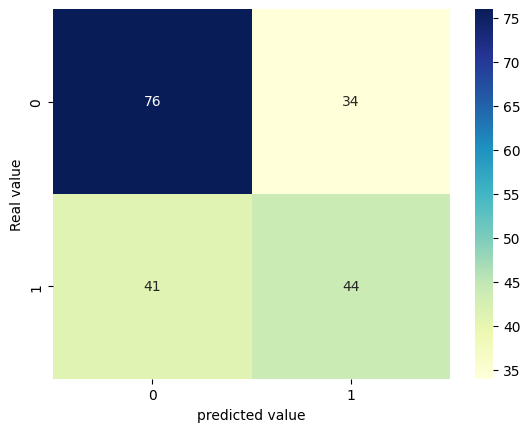

In [119]:
# Предположим, что у нас есть тестовый набор данных
test_dataset = FighterDataset(X_test, y_test)

test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Оценка модели на тестовых данных
net.eval()
test_y_pred_proba = []
test_y_true = []
with torch.no_grad():
    for batch in test_dataloader:
        x = batch['x']
        y = batch['y']
        outputs = net(x)
        y_pred_proba = torch.nn.functional.softmax(outputs, dim=1)
        test_y_pred_proba.extend(y_pred_proba.cpu().numpy())
        test_y_true.extend(y.cpu().numpy())

# Матрица ошибок
print(f'f1_score: {f1_score(y_true, y_pred, average='weighted'):.3f}')
test_y_pred = np.argmax(test_y_pred_proba, axis=1)
test_cm = confusion_matrix(test_y_true, test_y_pred)
# Выводим метрики качества модели
print("Classification Report:")
print(classification_report(test_y_true, test_y_pred))


sns.heatmap(test_cm,  annot=True, fmt='d', cmap='YlGnBu')
plt.ylabel('Real value')
plt.xlabel('predicted value')

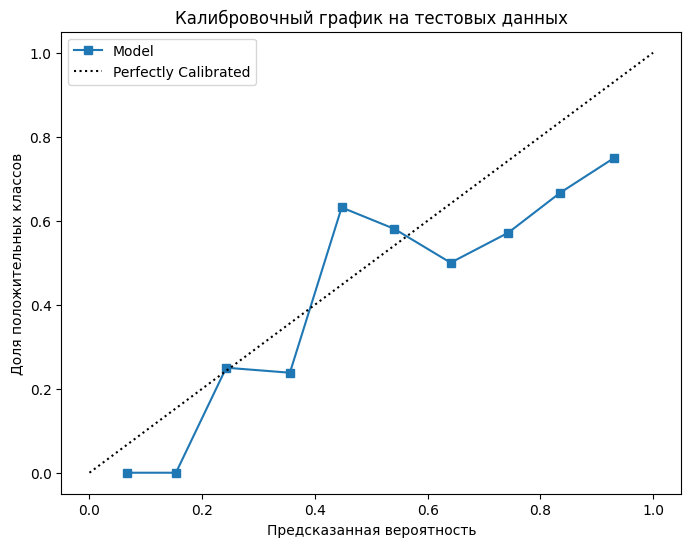

In [120]:
# Калибровочный график
plt.figure(figsize=(8, 6))
test_y_pred_proba_array = np.array(test_y_pred_proba)
fraction_of_positives, mean_predicted_value = calibration_curve(test_y_true, test_y_pred_proba_array[:, 1], n_bins=10)
plt.plot(mean_predicted_value, fraction_of_positives,'s-', label='Model')
plt.plot([0, 1], [0, 1], 'k:', label='Perfectly Calibrated')
plt.xlabel('Предсказанная вероятность')
plt.ylabel('Доля положительных классов')
plt.title('Калибровочный график на тестовых данных')
plt.legend()
plt.show()

### RNN

In [94]:
class MMADataSet(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X.values, dtype=torch.float32)
        self.y = torch.tensor(y.values, dtype=torch.float32)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

train_dataset = MMADataSet(X_train, y_train)
test_dataset = MMADataSet(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

### Базовая RNN

In [95]:
# Модель RNN
class RNNModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(RNNModel, self).__init__()
        self.rnn = nn.RNN(input_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        h0 = torch.zeros(1, x.size(0), self.rnn.hidden_size).to(x.device)
        out, _ = self.rnn(x.unsqueeze(1), h0)
        out = self.fc(out[:, -1, :])
        return torch.sigmoid(out)

### Больше слоев

In [97]:
class RNNModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(RNNModel, self).__init__()
        self.rnn = nn.LSTM(input_dim, hidden_dim, num_layers=2, batch_first=True)
        self.fc1 = nn.Linear(hidden_dim, 128)
        self.fc2 = nn.Linear(128, output_dim)
        self.dropout = nn.Dropout(0.2)

    def forward(self, x):
        x = x.unsqueeze(1)  # добавить размерность 1 для длины последовательности
        h0 = torch.zeros(self.rnn.num_layers, x.size(0), self.rnn.hidden_size).to(x.device)
        c0 = torch.zeros(self.rnn.num_layers, x.size(0), self.rnn.hidden_size).to(x.device)
        out, _ = self.rnn(x, (h0, c0))
        out = out[:, -1, :]
        out = self.dropout(out)
        out = torch.relu(self.fc1(out))
        out = self.dropout(out)
        out = self.fc2(out)
        return torch.sigmoid(out)

### Еще больше слоев

In [99]:
class RNNModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(RNNModel, self).__init__()
        self.rnn1 = nn.LSTM(input_dim, hidden_dim, num_layers=2, batch_first=True)
        self.rnn2 = nn.LSTM(hidden_dim, hidden_dim, num_layers=1, batch_first=True)
        self.fc1 = nn.Linear(hidden_dim, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, output_dim)
        self.dropout1 = nn.Dropout(0.2)
        self.dropout2 = nn.Dropout(0.2)
        self.dropout3 = nn.Dropout(0.2)

    def forward(self, x):
        x = x.unsqueeze(1)
        h0 = torch.zeros(self.rnn1.num_layers, x.size(0), self.rnn1.hidden_size).to(x.device)
        c0 = torch.zeros(self.rnn1.num_layers, x.size(0), self.rnn1.hidden_size).to(x.device)
        out, _ = self.rnn1(x, (h0, c0))
        h1 = torch.zeros(self.rnn2.num_layers, out.size(0), self.rnn2.hidden_size).to(x.device)
        c1 = torch.zeros(self.rnn2.num_layers, out.size(0), self.rnn2.hidden_size).to(x.device)
        out, _ = self.rnn2(out, (h1, c1))
        out = out[:, -1, :]
        out = self.dropout1(out)
        out = torch.relu(self.fc1(out))
        out = self.dropout2(out)
        out = torch.relu(self.fc2(out))
        out = self.dropout3(out)
        out = self.fc3(out)
        return torch.sigmoid(out)

Epoch 1, Loss: 0.5270775556564331
Epoch 2, Loss: 0.4992537498474121
Epoch 3, Loss: 0.5110861659049988
Epoch 4, Loss: 0.49362167716026306
Epoch 5, Loss: 0.5909742116928101
Epoch 6, Loss: 0.5564419031143188
Epoch 7, Loss: 0.5912521481513977
Epoch 8, Loss: 0.5391609072685242
Epoch 9, Loss: 0.5300321578979492
Epoch 10, Loss: 0.5547980070114136
Epoch 11, Loss: 0.5258662104606628
Epoch 12, Loss: 0.5206685066223145
Epoch 13, Loss: 0.47081029415130615
Epoch 14, Loss: 0.5539015531539917
Epoch 15, Loss: 0.5355126857757568
Epoch 16, Loss: 0.5271081924438477
Матрица ошибок:

Classification report:
{'0.0': {'precision': 0.6059602649006622, 'recall': 0.7379032258064516, 'f1-score': 0.6654545454545454, 'support': 248.0}, '1.0': {'precision': 0.6578947368421053, 'recall': 0.5122950819672131, 'f1-score': 0.576036866359447, 'support': 244.0}, 'accuracy': 0.6260162601626016, 'macro avg': {'precision': 0.6319275008713838, 'recall': 0.6250991538868323, 'f1-score': 0.6207457059069962, 'support': 492.0}, 'we

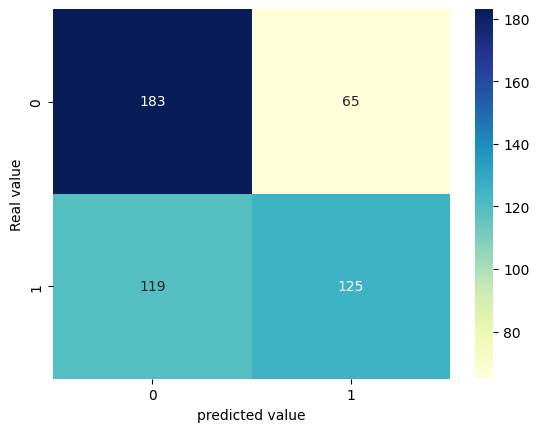

In [100]:
model = RNNModel(input_dim=X_train.shape[1], hidden_dim=128, output_dim=1)

# Обучение модели
criterion = nn.BCELoss()
optimizer = optim.Rprop(model.parameters(), lr=0.01)

for epoch in range(16):
    for batch in train_loader:
        inputs, labels = batch
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs.squeeze(), labels)
        loss.backward()
        optimizer.step()
    print(f'Epoch {epoch+1}, Loss: {loss.item()}')

# Оценка модели
model.eval()
with torch.no_grad():
    total_correct = 0
    predicted_labels = []
    test_labels = []
    for batch in test_loader:
        inputs, labels = batch
        outputs = model(inputs)
        predicted = (outputs > 0.5).float()
        predicted_labels.extend(predicted.numpy().flatten())
        test_labels.extend(labels.numpy().flatten())

# Преобразовать списки в numpy массивы
predicted_labels = np.array(predicted_labels)
test_labels = np.array(test_labels)

# Матрица ошибок
conf_mat = confusion_matrix(test_labels, predicted_labels)
print("Матрица ошибок:")
sns.heatmap(conf_mat,  annot=True, fmt='d', cmap='YlGnBu')
plt.ylabel('Real value')
plt.xlabel('predicted value')

# Classification report
print("\nClassification report:")
report = classification_report(test_labels, predicted_labels, output_dict=True)
print(report)

### Меняем количество нейронов в слое

In [101]:
class RNNModel(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(RNNModel, self).__init__()
        self.rnn1 = nn.LSTM(input_dim, 64, num_layers=2, batch_first=True)
        self.rnn2 = nn.LSTM(64, 32, num_layers=1, batch_first=True)
        self.fc1 = nn.Linear(32, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, output_dim)
        self.dropout1 = nn.Dropout(0.2)
        self.dropout2 = nn.Dropout(0.2)
        self.dropout3 = nn.Dropout(0.2)

    def forward(self, x):
        x = x.unsqueeze(1)
        h0 = torch.zeros(self.rnn1.num_layers, x.size(0), self.rnn1.hidden_size).to(x.device)
        c0 = torch.zeros(self.rnn1.num_layers, x.size(0), self.rnn1.hidden_size).to(x.device)
        out, _ = self.rnn1(x, (h0, c0))
        h1 = torch.zeros(self.rnn2.num_layers, out.size(0), self.rnn2.hidden_size).to(x.device)
        c1 = torch.zeros(self.rnn2.num_layers, out.size(0), self.rnn2.hidden_size).to(x.device)
        out, _ = self.rnn2(out, (h1, c1))
        out = out[:, -1, :]
        out = self.dropout1(out)
        out = torch.relu(self.fc1(out))
        out = self.dropout2(out)
        out = torch.relu(self.fc2(out))
        out = self.dropout3(out)
        out = self.fc3(out)
        return torch.sigmoid(out)

f1_score: 0.6372360341960907

Классификационный отчет:
              precision    recall  f1-score   support

           0       0.62      0.76      0.68       248
           1       0.68      0.52      0.59       244

    accuracy                           0.64       492
   macro avg       0.65      0.64      0.64       492
weighted avg       0.65      0.64      0.64       492



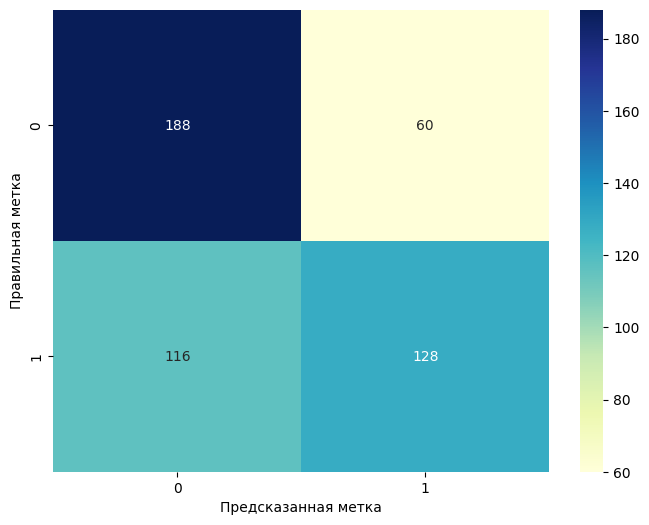

In [106]:
# Определение модели
import torch.optim.rprop


model = RNNModel(input_dim=18, output_dim=2)

# Определение функции потерь и оптимизатора
criterion = nn.BCELoss()
optimizer = torch.optim.Rprop(model.parameters(), lr=0.01)

# Обучение модели
for epoch in range(15):
    model.train()
    total_loss = 0
    for batch in train_loader:
        inputs, labels = batch
        labels = labels[:, None]  # добавляем новый размерность
        labels = torch.cat((1 - labels, labels), dim=1)  # преобразуем в бинарный формат
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    # print(f'Эпоха {epoch+1}, потеря: {total_loss / len(train_loader)}')

# Оценка модели на тестовой выборке
model.eval()
test_loss = 0
correct = 0
predicted_labels = []
test_labels = []
with torch.no_grad():
    for batch in test_loader:
        inputs, labels = batch
        labels = labels[:, None]  # добавляем новый размерность
        labels = torch.cat((1 - labels, labels), dim=1)  # преобразуем в бинарный формат
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        test_loss += loss.item()
        predicted = torch.argmax(outputs, dim=1)  # получаем индекс максимальной вероятности
        correct += (predicted == torch.argmax(labels, dim=1)).sum().item()
        predicted_labels.extend(predicted.cpu().numpy())
        test_labels.extend(torch.argmax(labels, dim=1).cpu().numpy())

# Матрица ошибок
conf_mat = confusion_matrix(test_labels, predicted_labels)
print(f'f1_score: {f1_score(test_labels, predicted_labels, average='weighted')}')

# Классификационный отчет
print("\nКлассификационный отчет:")
print(classification_report(test_labels, predicted_labels))

# Визуализация матрицы ошибок
plt.figure(figsize=(8, 6))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap="YlGnBu")
plt.xlabel("Предсказанная метка")
plt.ylabel("Правильная метка")
plt.show()